# setup

In [1]:
import json
import numpy as np
import base64
import zlib
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from skimage.io import imread
import re
import cv2 as cv
import torch
import traceback

In [2]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/"
new_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/"

img_folder = root + "img/original/"
mask_folder = root + "ann/json/"

# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}
categories_list = list(category_mapping.values())

In [3]:
files = os.listdir(mask_folder)
n_masks = []

regex_string = r"(.+)\.(jpg|tiff)\.json"

for f in files:
    match = re.search(regex_string, f)
    if match:
        n_masks.append(match.group(1))


-----

# conversion code

In [4]:
def convert_json_to_multihot(json_file_path, image):
    """
    Converts a JSON mask file into a multi-hot encoded NumPy array file.

    Parameters:
      json_file_path: Path to the JSON file containing the annotations.
      output_file_path: Path to save the resulting .npy multi-hot encoded mask.
      mapping: A dict mapping classTitle strings (from JSON) to channel indices.

    The resulting NumPy array will have shape (4, height, width) where each channel
    corresponds to one class in your segmentation task.
    """
    # Load JSON data
    with open(json_file_path, "r") as f:
        data = json.load(f)

    # Get image dimensions from the JSON
    height = data["size"]["height"]
    width = data["size"]["width"]

    # Create an empty multi-hot mask with 4 channels.
    # Channels: 0 = dark, 1 = busbar, 2 = crack, 3 = non-cell.
    multi_hot = np.zeros((4, height, width), dtype=np.uint8)

    try:
        objects = data["objects"]
    except KeyError:
        objects = data["annotation"]["objects"]

    for obj in objects:
        if obj["geometryType"] == "bitmap":
            code = obj["bitmap"]["data"]
            origin = obj["bitmap"]["origin"]

            z = zlib.decompress(base64.b64decode(code))
            n = np.frombuffer(z, np.uint8)
            mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)

            # This is some unfortunate maneuvering to address the fact that
            # bitmap annotations do not usually come in the same size as the
            # image from which they were labeled, and so it is necessary to
            # situate the annotation in an otherwise empty array that is the
            # same size as the image

            mask_center = np.array([mask.shape[1] / 2, mask.shape[0] / 2])
            mask_center += origin
            up = np.zeros((origin[1], mask.shape[1]))
            mask2 = np.vstack((up, mask))
            left = np.zeros((mask2.shape[0], origin[0]))
            mask3 = np.hstack((left, mask2))
            down = np.zeros((image.shape[0] - mask3.shape[0], mask3.shape[1]))
            mask4 = np.vstack((mask3, down))
            right = np.zeros((mask4.shape[0], image.shape[1] - mask4.shape[1]))
            mask5 = np.hstack((mask4, right)).astype(bool)

        elif obj["geometryType"] == "rectangle":
            # Handle rectangle masks
            points = obj["points"]["exterior"]
            x1, y1 = points[0]
            x2, y2 = points[1]

            mask5 = np.zeros(image.shape[:-1]).astype(bool)
            mask5[y1:y2, x1:x2] = True

        for idx, category in enumerate(categories_list):
            if category in obj["classTitle"].lower():
                multi_hot[idx] = np.logical_or(multi_hot[idx], mask5).astype(bool)

    return multi_hot

---

## viz stuff

In [5]:
def stack_masks(
    multihot, image
):
    # Stack the four n_x by n_y feature arrays
    all_masks = torch.dstack([torch.tensor(v) for v in multihot]).permute(2, 0, 1)

    new_tensor = torch.zeros(
        [all_masks.shape[1], all_masks.shape[2]], dtype=torch.float64
    )

    for channel in [0, 1, 2, 3]:
        new_tensor[all_masks[channel].bool()] = channel + 1

    return new_tensor
    

In [6]:
def plot_and_show_labels(cracks_mask):
    fig, ax = plt.subplots()

    clim = (0, 4)
    ax.imshow(cracks_mask, clim=clim, interpolation="None")

    # Do legend
    cmap = mpl.colormaps["viridis"].resampled(4)  # define the colormap
    cmaplist = [cmap(i) for i in range(4)]
    handles, labels = ax.get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax.legend(handles=handles, fontsize="x-small")

    ax.axis("off")

In [7]:
def inference_and_show(img, gt_mask):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10, 10), layout="compressed")

    ax[0, 0].imshow(img, cmap="gray", interpolation="None")
    ax[0, 0].axis("off")
    ax[0, 0].set_title("(a) EL image", fontsize="xx-large")
    ##
    for i in range(4):
        ax[1, i].imshow(gt_mask[i], cmap="viridis", interpolation="None")
        ax[1, i].axis("off")
        ax[1, i].set_title(f"({i}) {category_mapping[i]} activation")

------

# Converting all masks

In [8]:
for index, n in enumerate(n_masks):
    try:
        image_file_extension = "jpg"
        mask_path = os.path.join(mask_folder, f"{n}.{image_file_extension}.json")
        img_path = os.path.join(img_folder, f"{n}.{image_file_extension}")
        image = imread(img_path)
    except FileNotFoundError:
        try:
            image_file_extension = "tiff"
            mask_path = os.path.join(mask_folder, f"{n}.{image_file_extension}.json")
            img_path = os.path.join(img_folder, f"{n}.{image_file_extension}")
            image = imread(img_path)
        except Exception as e:
            traceback.format_exc()

    multihot = convert_json_to_multihot(mask_path, image)

    output_file_path = new_root + "ann/channeled/" + f"{n}.npy"
    np.save(output_file_path, multihot, allow_pickle=False)

    print(f"Saved {index + 1}/{len(n_masks)}: {output_file_path}")

Saved 1/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/SW1-DH3000-1500h-PT-cell50.npy
Saved 2/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/SW3-DH3000-1000h-PT-cell18-r180.npy
Saved 3/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/SW1-DH3000-1000h-PT-cell19-flr.npy
Saved 4/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/SW2-DH3000-1500h-PT-cell57.npy
Saved 5/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/SW1-DH3000-500h-PT-cell34-r180.npy
Saved 6/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/ann/channeled/1578.npy
Saved 7/585: /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combi

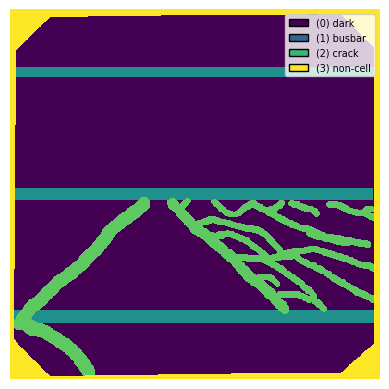

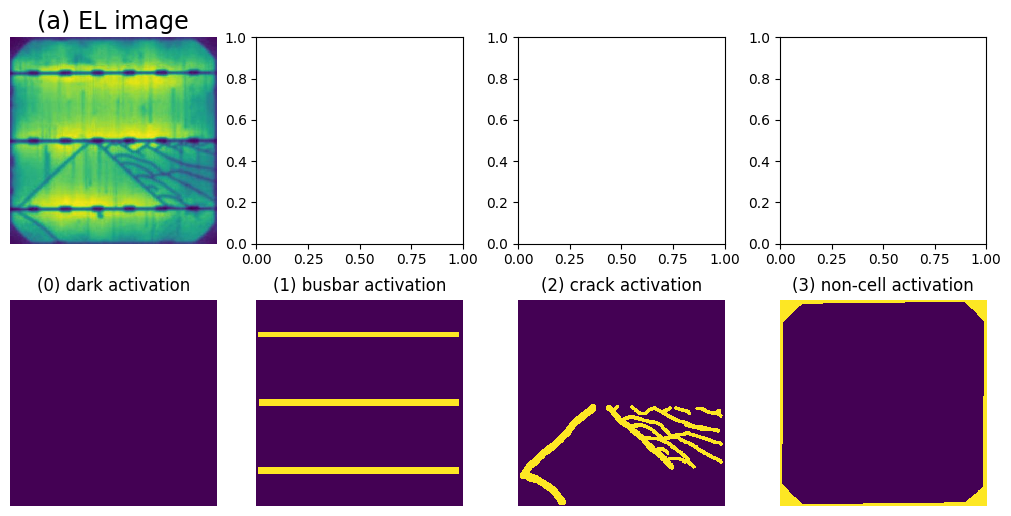

In [9]:
stacked = stack_masks(multihot, image)

plot_and_show_labels(stacked)

inference_and_show(image, multihot)